# HOUSE PRICE PREDICTION 3 MODELS (CNN, LSTM1, LSTM2)

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\carlo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\carlo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## CNN

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Data Preparation:

data = pd.read_csv('raw_sales.csv')
data['datesold'] = pd.to_datetime(data['datesold']).apply(lambda x: x.toordinal())

if 'propertyType' in data.columns:
    encoder = OneHotEncoder()
    propertyType_encoded = encoder.fit_transform(data[['propertyType']])
    feature_names = encoder.get_feature_names_out(['propertyType'])
    data = pd.concat([data, pd.DataFrame(propertyType_encoded.toarray(), columns=feature_names)], axis=1)
    data.drop('propertyType', axis=1, inplace=True)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

sequence_length = 10  # Increased sequence length

def generate_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])
        y.append(data[i+sequence_length, -1])
    return np.array(X), np.array(y)

X, y = generate_sequences(data_scaled, sequence_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(2/9), random_state=42) # This gives 70% train, 20% validation

X_train_tensor = torch.FloatTensor(X_train).permute(0, 2, 1)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val).permute(0, 2, 1)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test).permute(0, 2, 1)
y_test_tensor = torch.FloatTensor(y_test)

# DataLoader for batch training
batch_size = 64
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# 2. Model Construction:

class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.5)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.5)
        )
        
        after_conv1 = (sequence_length - 3 + 1) // 2
        after_conv2 = (after_conv1 - 2 + 1) // 2
        self.fc = nn.Linear(128 * after_conv2, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


input_dim = X_train_tensor.shape[1]
model = CNNModel(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Training and Validation:

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs_train = model(batch_X)
        loss_train = criterion(outputs_train, batch_y.unsqueeze(1))
        loss_train.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor.unsqueeze(1))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

# 4. Test Evaluation:

model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    loss_test = criterion(outputs_test, y_test_tensor.unsqueeze(1))

print(f"Test Loss: {loss_test.item():.4f}")


Epoch 1/15, Training Loss: 0.0029, Validation Loss: 0.0029
Epoch 2/15, Training Loss: 0.0157, Validation Loss: 0.0131
Epoch 3/15, Training Loss: 0.0041, Validation Loss: 0.0099
Epoch 4/15, Training Loss: 0.0077, Validation Loss: 0.0039
Epoch 5/15, Training Loss: 0.0084, Validation Loss: 0.0030
Epoch 6/15, Training Loss: 0.0038, Validation Loss: 0.0011
Epoch 7/15, Training Loss: 0.0045, Validation Loss: 0.0084
Epoch 8/15, Training Loss: 0.0025, Validation Loss: 0.0066
Epoch 9/15, Training Loss: 0.0036, Validation Loss: 0.0069
Epoch 10/15, Training Loss: 0.0038, Validation Loss: 0.0023
Epoch 11/15, Training Loss: 0.0061, Validation Loss: 0.0064
Epoch 12/15, Training Loss: 0.0154, Validation Loss: 0.0115
Epoch 13/15, Training Loss: 0.0014, Validation Loss: 0.0086
Epoch 14/15, Training Loss: 0.0023, Validation Loss: 0.0035
Epoch 15/15, Training Loss: 0.0096, Validation Loss: 0.0098
Test Loss: 0.0100


## LSTM-1 sin tiempo

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Preparación de Datos:

# Cargar el conjunto de datos de entrenamiento
data = pd.read_csv('raw_sales.csv')

# Convertir la columna datesold a un número ordinal
data['datesold'] = pd.to_datetime(data['datesold']).apply(lambda x: x.toordinal())

# Codificar la columna propertyType
if 'propertyType' in data.columns:
    encoder = OneHotEncoder()
    propertyType_encoded = encoder.fit_transform(data[['propertyType']])
    feature_names = encoder.get_feature_names_out(['propertyType'])
    data = pd.concat([data, pd.DataFrame(propertyType_encoded.toarray(), columns=feature_names)], axis=1)
    data.drop('propertyType', axis=1, inplace=True)

# Normalizar los valores
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Generar secuencias para el entrenamiento
sequence_length = 3

def generate_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])
        y.append(data[i+sequence_length, -1])
    return np.array(X), np.array(y)

X, y = generate_sequences(data_scaled, sequence_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.22, random_state=42)  # 0.22 x 0.9 = 0.2

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# 2. Construcción del Modelo:

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

input_dim = X_train_tensor.shape[2]
hidden_dim = 50
model = LSTMModel(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Entrenamiento y Validación:

num_epochs = 50
for epoch in range(num_epochs):
    # Entrenamiento
    optimizer.zero_grad()
    outputs_train = model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor.unsqueeze(1))
    loss_train.backward()
    optimizer.step()
    
    # Validación
    model.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor.unsqueeze(1))
    model.train()  # Regresar el modelo al modo de entrenamiento

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

# 4. Evaluación del Conjunto de Test:

model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    loss_test = criterion(outputs_test, y_test_tensor.unsqueeze(1))

print(f"Test Loss: {loss_test.item():.4f}")

Epoch 1/50, Training Loss: 0.1442, Validation Loss: 0.1279
Epoch 2/50, Training Loss: 0.1275, Validation Loss: 0.1161
Epoch 3/50, Training Loss: 0.1158, Validation Loss: 0.1016
Epoch 4/50, Training Loss: 0.1013, Validation Loss: 0.0844
Epoch 5/50, Training Loss: 0.0841, Validation Loss: 0.0666
Epoch 6/50, Training Loss: 0.0663, Validation Loss: 0.0475
Epoch 7/50, Training Loss: 0.0473, Validation Loss: 0.0268
Epoch 8/50, Training Loss: 0.0267, Validation Loss: 0.0158
Epoch 9/50, Training Loss: 0.0158, Validation Loss: 0.0164
Epoch 10/50, Training Loss: 0.0164, Validation Loss: 0.0288
Epoch 11/50, Training Loss: 0.0289, Validation Loss: 0.0283
Epoch 12/50, Training Loss: 0.0282, Validation Loss: 0.0174
Epoch 13/50, Training Loss: 0.0173, Validation Loss: 0.0087
Epoch 14/50, Training Loss: 0.0087, Validation Loss: 0.0040
Epoch 15/50, Training Loss: 0.0040, Validation Loss: 0.0036
Epoch 16/50, Training Loss: 0.0037, Validation Loss: 0.0062
Epoch 17/50, Training Loss: 0.0063, Validation Lo

## LSTM-2

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Data Preparation:

# Loading Data
data = pd.read_csv('raw_sales.csv')

# Convert the 'datesold' column to ordinal numbers
data['datesold'] = pd.to_datetime(data['datesold']).apply(lambda x: x.toordinal())

# Extract 'datesold' and 'price' columns
data = data[['datesold', 'price']]

# Normalize the values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Generate sequences for training
sequence_length = 3

def generate_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 0])  # Only 'datesold' values
        y.append(data[i+sequence_length, 1])  # Corresponding 'price' value
    return np.array(X), np.array(y)

X, y = generate_sequences(data_scaled, sequence_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.22, random_state=42)  # 0.22 x 0.9 = 0.2

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(2)  # Adding an extra dimension for LSTM
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val).unsqueeze(2)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(2)
y_test_tensor = torch.FloatTensor(y_test)

# 2. Model Construction:

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

input_dim = 1  # We're only using the 'datesold' column
hidden_dim = 50
model = LSTMModel(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Training and Validation:

num_epochs = 50
for epoch in range(num_epochs):
    # Training
    optimizer.zero_grad()
    outputs_train = model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor.unsqueeze(1))
    loss_train.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor.unsqueeze(1))
    model.train()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

# 4. Test Set Evaluation:

model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    loss_test = criterion(outputs_test, y_test_tensor.unsqueeze(1))

print(f"Test Loss: {loss_test.item():.4f}")


Epoch 1/50, Training Loss: 0.0115, Validation Loss: 0.0012
Epoch 2/50, Training Loss: 0.0013, Validation Loss: 0.0054
Epoch 3/50, Training Loss: 0.0055, Validation Loss: 0.0046
Epoch 4/50, Training Loss: 0.0047, Validation Loss: 0.0021
Epoch 5/50, Training Loss: 0.0022, Validation Loss: 0.0011
Epoch 6/50, Training Loss: 0.0013, Validation Loss: 0.0016
Epoch 7/50, Training Loss: 0.0018, Validation Loss: 0.0023
Epoch 8/50, Training Loss: 0.0025, Validation Loss: 0.0025
Epoch 9/50, Training Loss: 0.0027, Validation Loss: 0.0022
Epoch 10/50, Training Loss: 0.0023, Validation Loss: 0.0017
Epoch 11/50, Training Loss: 0.0018, Validation Loss: 0.0013
Epoch 12/50, Training Loss: 0.0014, Validation Loss: 0.0011
Epoch 13/50, Training Loss: 0.0013, Validation Loss: 0.0012
Epoch 14/50, Training Loss: 0.0014, Validation Loss: 0.0015
Epoch 15/50, Training Loss: 0.0016, Validation Loss: 0.0016
Epoch 16/50, Training Loss: 0.0017, Validation Loss: 0.0016
Epoch 17/50, Training Loss: 0.0017, Validation Lo

Epoch 1/50, Training Loss: 0.0133, Validation Loss: 0.0013
Epoch 2/50, Training Loss: 0.0015, Validation Loss: 0.0057
Epoch 3/50, Training Loss: 0.0059, Validation Loss: 0.0048
Epoch 4/50, Training Loss: 0.0050, Validation Loss: 0.0018
Epoch 5/50, Training Loss: 0.0020, Validation Loss: 0.0012
Epoch 6/50, Training Loss: 0.0013, Validation Loss: 0.0020
Epoch 7/50, Training Loss: 0.0022, Validation Loss: 0.0029
Epoch 8/50, Training Loss: 0.0030, Validation Loss: 0.0030
Epoch 9/50, Training Loss: 0.0031, Validation Loss: 0.0025
Epoch 10/50, Training Loss: 0.0027, Validation Loss: 0.0019
Epoch 11/50, Training Loss: 0.0020, Validation Loss: 0.0013
Epoch 12/50, Training Loss: 0.0015, Validation Loss: 0.0011
Epoch 13/50, Training Loss: 0.0013, Validation Loss: 0.0013
Epoch 14/50, Training Loss: 0.0014, Validation Loss: 0.0016
Epoch 15/50, Training Loss: 0.0017, Validation Loss: 0.0018
Epoch 16/50, Training Loss: 0.0019, Validation Loss: 0.0017
Epoch 17/50, Training Loss: 0.0019, Validation Lo

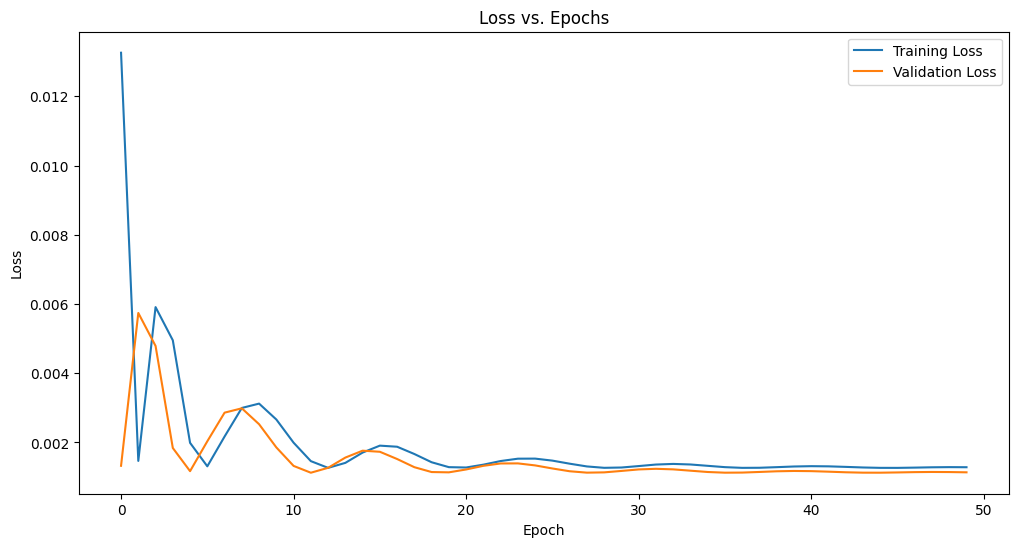

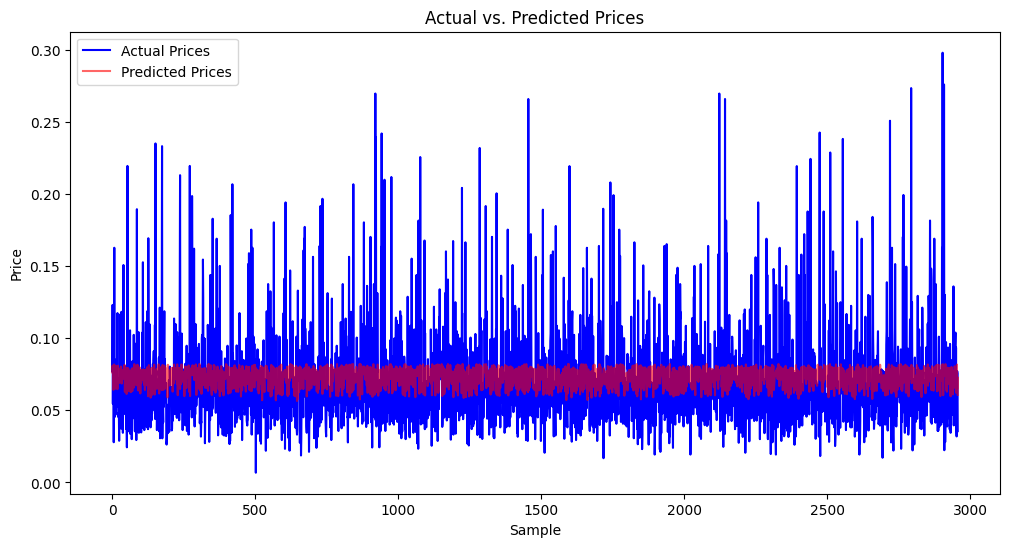

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Data Preparation:

# Load the dataset
data = pd.read_csv('raw_sales.csv')

# Convert the 'datesold' column to an ordinal number
data['datesold'] = pd.to_datetime(data['datesold']).apply(lambda x: x.toordinal())

# Use only the 'datesold' and 'price' columns
data = data[['datesold', 'price']]

# Normalize the values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Generate sequences for training
sequence_length = 3

def generate_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 0])  # We only take the 'datesold' column here
        y.append(data[i+sequence_length, 1])  # 'price' column
    return np.array(X), np.array(y)

X, y = generate_sequences(data_scaled, sequence_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.22, random_state=42)  # 0.22 x 0.9 = 0.2

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(2)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val).unsqueeze(2)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(2)
y_test_tensor = torch.FloatTensor(y_test)

# 2. Model Building:

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

input_dim = 1  # Only 'datesold'
hidden_dim = 50
model = LSTMModel(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Training and Validation:

num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    optimizer.zero_grad()
    outputs_train = model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor.unsqueeze(1))
    loss_train.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor.unsqueeze(1))
    model.train()

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

# 4. Testing:

model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    loss_test = criterion(outputs_test, y_test_tensor.unsqueeze(1))

print(f"Test Loss: {loss_test.item():.4f}")

# 5. Visualizations:

# Loss vs. Epochs
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Actual vs. Predicted Prices on Test Set
predicted_prices = outputs_test.numpy()
actual_prices = y_test

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red', alpha=0.6)
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()
